# Imports

In [ ]:
import joblib
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    RocCurveDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay,
    classification_report,
)

#Data Loading

In [ ]:
data = joblib.load("data_splits.pkl") ## Load the pre-processed data splits from the pickle file

#Extract the training, validation, and testing data
X_train = data["X_train"]
X_val = data["X_val"]
X_test = data["X_test"]
y_train = data["y_train"]
y_val = data["y_val"]
y_test = data["y_test"]

# Nearest Centroid Classifier Class

In [ ]:
class NearestCentroid:
    def __init__(self, metric='euclidean'):
        self.metric = metric
        self.centroids = {}

    def fit(self, X, y):
        """
        Trains the Nearest Centroid model.
        """
        unique_labels = np.unique(y)
        for label in unique_labels:
            self.centroids[label] = X[y == label].mean(axis=0).astype(np.float64)

    def predict(self, X):
        """
        Predicts labels for new data points.
        """
        X = X.select_dtypes(include=np.number).astype(np.float64) # Select only numerical features

        predictions = []
        for x in X.values: # Iterate over the NumPy array of the DataFrame
            distances = {label: self._distance(x, centroid) for label, centroid in self.centroids.items()}
            predicted_label = min(distances, key=distances.get)
            predictions.append(predicted_label)
        return np.array(predictions)

    def _distance(self, x1, x2):
        """
        Calculates the distance between two points.
        """
        if self.metric == 'euclidean':
            return np.sqrt(np.sum((x1 - x2) ** 2))
        elif self.metric == 'manhattan':
            return np.sum(np.abs(x1 - x2))
        else:
            raise ValueError("Invalid metric. Choose 'euclidean' or 'manhattan'.")

    def predict_proba(self, X):
        """Predicts probabilities for new data points."""
        X = X.select_dtypes(include=np.number).astype(np.float64)

        probabilities = []
        for x in X.values:
           #Calculate distances to each centroid.
            distances = {label: self._distance(x, centroid) for label, centroid in self.centroids.items()}
            # probability of class 1 is inversely proportional to distance
            prob_class_1 = 1 / (distances[1] + 1e-6)  # Add small value to avoid division by zero
            prob_class_0 = 1 - prob_class_1
            probabilities.append([prob_class_0, prob_class_1])
        return np.array(probabilities)

# Training and Evaluation

In [ ]:
best_accuracy = 0
best_metric = None

# Hyperparameter options (metric)
metrics = ['euclidean', 'manhattan']

for metric in metrics:
    model = NearestCentroid(metric=metric)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)  # Calculate accuracy

    print(f"Metric: {metric}, Validation Accuracy: {accuracy:.4f}") # Print validation accuracy

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_metric = metric

print(f"\nBest Metric: {best_metric}, Best Validation Accuracy: {best_accuracy:.4f}")

# Train the final model with the best hyperparameter

final_model = NearestCentroid(metric=best_metric)
final_model.fit(X_train, y_train)

# Evaluate on the test set
y_test_probs = final_model.predict_proba(X_test)[:, 1]
y_pred_test = final_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

Metric: euclidean, Validation Accuracy: 0.7179
Metric: manhattan, Validation Accuracy: 0.8417

Best Metric: manhattan, Best Validation Accuracy: 0.8417
Test Accuracy: 0.8457


# Confusion Matrix

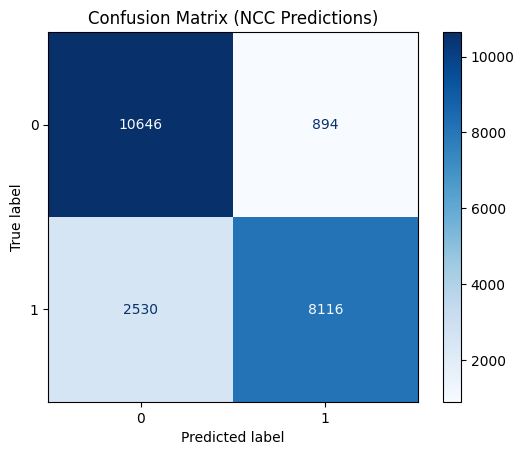

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (NCC Predictions)")
plt.show()

# ROC curve

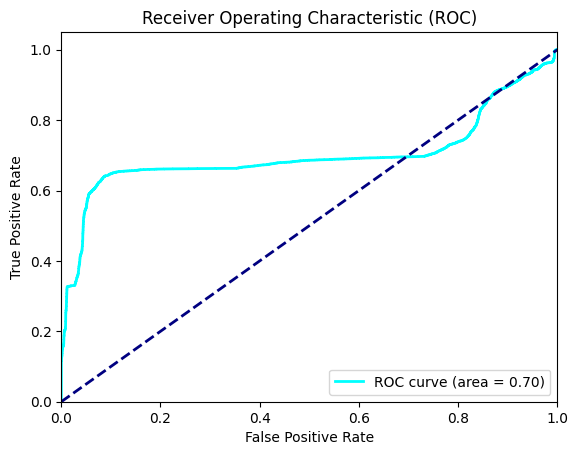

In [ ]:
# calculate the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, _ = roc_curve(y_test, y_test_probs)
roc_auc = auc(fpr, tpr) # Calculate the area under the ROC curve (AUC)

plt.figure()
plt.plot(fpr, tpr, color='cyan', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


# Precision-Recall Curve


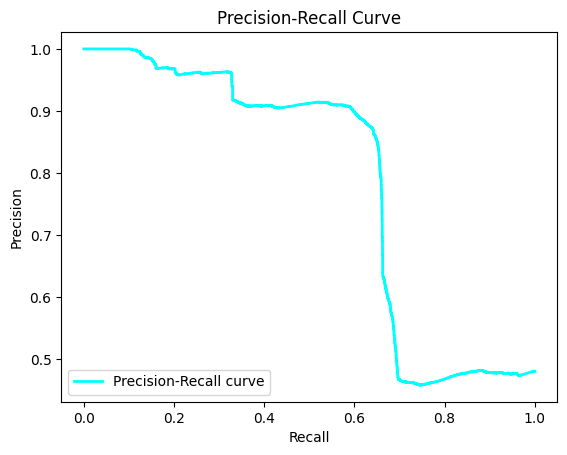

In [ ]:
# Calculate precision and recall values at different thresholds
precision, recall, _ = precision_recall_curve(y_test, y_test_probs)

plt.figure()
plt.plot(recall, precision, color='cyan', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Classification Report

In [ ]:
report = classification_report(y_test, y_pred_test, output_dict=True)  # Get report as dict
df_report = pd.DataFrame(report).transpose()  # Convert to DataFrame
display(df_report)

,precision,recall,f1-score,support
0,0.807984,0.922530,0.861466,11540.000000
1,0.900777,0.762352,0.825804,10646.000000
accuracy,0.845668,0.845668,0.845668,0.845668
macro avg,0.854381,0.842441,0.843635,22186.000000
weighted avg,0.852511,0.845668,0.844354,22186.000000
